# News Classification with Machine Learning

This project demonstrates an application of natural language processing (NLP) to classify news stories.

## Overview
The notebook should be run in order. More details are documented with each section and in comments on code.
1. Load and setup data
2. Vectorize data
3. Group categories using K-means clustering
4. Visualize category clusters
5. Visualize cluster features (keywords)
6. Train classification model
7. Predict from user input

## **1** - Load and Setup Data

1. Load data from json file
2. Split into x (input, independent variable) and y (output, dependent variable)
3. Split into train (80%) and test (remaining 20%)
4. Create new articles_by_category dataframe with all text grouped into each category to use for clustering categories together

### About the source dataset
Load data from the CSV in the input directory.
Data is structured as individual JSON lines with the following properties:

| Column Name        | Type       | Description                    |
|:-------------------|:-----------|:-------------------------------|
| category           | category   | One of 42 categories           |
| headline           | string     | Story headline                 |
| short_description  | string     | Brief description of the story |
| link               | string     | URL to story                   |
| authors            | string     | Name of article authors        |
| date               | YYYY-MM-DD | Date article was published     |

#### Data source
    Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
    Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).
    https://rishabhmisra.github.io/publications/

In [1618]:
import pandas as pd

df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)
df['category'] = df['category'].astype('category') # Set category column as panda's category type to ensure efficient processing


from sklearn.model_selection import train_test_split

x = df['headline'] + ' ' + df['short_description'] # x, input, independent variable, is all text headline + short_description
y = df[['category']] # y, output, dependent variable, is dataframe with only category column

# Split data into train (80%) and test (remaining 20%). Use stratify to ensure even split of categories
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y['category'], random_state=5)

# Group training data by category
articles_by_category = (
    x_train
        .groupby(y_train['category'], observed=True)
        .apply(lambda article: ' '.join(article.astype(str))) # all_articles column contains text from all articles for the category
        .reset_index(name='all_articles')
)

category_names = articles_by_category['category']

## **2** - Vectorize Data

Using a term frequency - inverse document frequency (TF-IDF) algorithm, extract the top 15k words used amongst all categories. Use a score to determine weight of each term based on frequency and uniqueness to a specific category.

1. Articles are tokenized
    1. **Separate** "all_articles" by words into a list
    2. **Lowercase** all words so words like "President" and "president" are treated as equal
    3. **Lemmatize** each word so "runs" and "run" are treated as equal
    4. Filter out **stop words** so words like "the" and "and" that do not add meaning do not skew results.
    5. Filter out words **less than 3 characters**.
2. Count terms in each document
3. Score term frequency by determining frequency in individual documents and weighting terms that are more distinct in particular documents
4. Limit to top 15k words (max features)

In [1626]:
import nltk
import subprocess
import sys
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

'''
Download data needed for tokenization
'''
try:
    nltk.data.find('wordnet') # Attempt to locate wordnet
except LookupError:
    # When wordnet data is not found, download to working directory and unzip.
    nltk.download('wordnet', download_dir='../working/', quiet=True)
    if sys.platform.startswith('linux'): # Unzip is necessary on Kaggle but this will work in any linux based environment
        command = "unzip ../working/corpora/wordnet.zip -d ../working/corpora"
        subprocess.run(command.split())
        nltk.data.path.append('../working/')

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

'''
TF-IDF Vectorizer
'''
# lemmatizer is used to convert words to a common version. For example, "runs" and "run" become "run"
lemmatizer = WordNetLemmatizer()
# stopwords are common words that do not add meaning. Words like "the" "and" add noise so this list can filter these
stopwords_list = stopwords.words('english') + ['want', 'say', 'way', 'need', 'said', 'get', 'like', 'could', 'thing']

# Define tokenizer function for use during vectorization
def tokenizer(text):
    # tokenize the string - split the sentence to the individual words, remove non-alphanumeric characters, and lowercase the tokens
    tokens = [re.sub(r'[^A-Za-z0-9]', '', t).strip() for t in word_tokenize(text.lower())]
    # remove stopwords and words less than 3 characters
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_list and len(token) > 2]

# TfidfVectorizer counts words in each document, then uses the TF-IDF algorithm to determine each term (features) weight
vectorizer_settings = dict(tokenizer=tokenizer, max_features=15000, token_pattern=None)
vectorizer = TfidfVectorizer(**vectorizer_settings)
# Apply vectorizer to the articles by category dataframe
tfidf_category_matrix = vectorizer.fit_transform(articles_by_category['all_articles'])

## **3** - Group Categories Using K-Means Clustering

Use the K-Means clustering algorithm to determine categories that should be grouped together. The K-Means algorithm is an unsupervised clustering algorithm used to identify a specific number of clusters from the provided data.

1. Find clusters using K-Means algorithm
2. Calculate mean TF-IDF matrix for each cluster
3. Find the dominant categories in each cluster using the cosine_similarity to the cluster TF-IDF matrix (60%) and article count (40%)
4. Use the top categories for the cluster to create a cluster name in the format "Category 1 - Category 2 - Category 3" where "Category #" is the name of the category.
5. Add a column to the y dataframes with the cluster name

In [1620]:
from sklearn.cluster import KMeans
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

'''
K-Means Clustering

Find specific number of clusters
'''
kmeans = KMeans(n_clusters=4, random_state=20, max_iter=500, init='random', n_init=300)
kmeans_results = kmeans.fit(tfidf_category_matrix)

'''
 For each category, find the assigned cluster. Use cluster_categories dict to store the list of categories for each cluster.

 Example where 6 categories are clustered in two groups:
    # input
    kmeans_results.labels_ == [1, 1, 0, 0, 1, 1]
    # expected output
    cluster_categories == {
        0: [2, 3],
        1: [0, 1, 4, 5]
    }
'''
cluster_categories = defaultdict(list)
for i, label in enumerate(kmeans_results.labels_):
    cluster_categories[label].append(i)

# Find mean for all TF-IDF matrices in each cluster.
cluster_tfidf_matrices = {}
for cluster_id, category_indices in cluster_categories.items():
    cluster_tfidf_matrices[cluster_id] = np.asarray(np.mean(tfidf_category_matrix[category_indices], axis=0))

# Use mean matrices to determine dominant categories in each cluster
dominant_categories = [] # After following for loop, result in name of each cluster using dominant categories in each cluster
category_dominance_scores = [0] * len(category_names) # Initialize an array of 0 for each category
for cluster_id, category_indices in cluster_categories.items(): # Use cluster_categories generated above
    # Compare each category TF-IDF matrix to the overall cluster TF-IDF mean matrix using cosine similarity.
    # Cosine similarity compares the **angle** between the vectors which ensures clusters with more articles are not unfairly weighted at this stage.
    cluster_tfidf = cluster_tfidf_matrices[cluster_id]
    similarity = cosine_similarity(tfidf_category_matrix[category_indices], cluster_tfidf)

    # Get the article counts for each category using the x_train (from before the articles_by_category grouping)
    article_counts = np.array([len(x_train[y_train['category'] == category_names[i]]) for i in category_indices])
    article_counts = article_counts / article_counts.sum() # normalize counts

    # Use a combination of similarity and article count with a high weight on the TF-IDF similarity aspect
    combined_scores = 0.6 * similarity.flatten() + 0.4 * article_counts

    top_3_indices = np.argsort(combined_scores)[-3:][::-1] # Find top 3 scores - returns indices of combined_scores
    top_3_names = [category_names[category_indices[i]] for i in top_3_indices] # Use top_3 indexes to index over the category_indices and map to category names

    dominant_categories.append(" - ".join(top_3_names)) # Join top_3_names with " - " between each category

    # Store dominance scores to be used by the 3D scatter plot later
    # Will inform the size of the scatter points to show dominance within the category
    for list_idx, cat_idx in enumerate(category_indices):
        category_dominance_scores[cat_idx] = combined_scores[list_idx]

def map_to_cluster(category):
    sub_cat_idx = articles_by_category[articles_by_category['category'] == category].index[0] # Determine index for matching category string
    cluster_idx = kmeans_results.labels_[sub_cat_idx] # Use index to find cluster index
    return dominant_categories[cluster_idx] # use name instead of cluster number

# Add the clusters as a new column on the training data
y_train['cluster_category'] = y_train['category'].map(map_to_cluster).astype('category')
y_test['cluster_category'] = y_test['category'].map(map_to_cluster).astype('category')

print(dominant_categories)

['ENTERTAINMENT - STYLE & BEAUTY - ARTS', 'WELLNESS - IMPACT - HEALTHY LIVING', 'POLITICS - WORLD NEWS - THE WORLDPOST', 'FOOD & DRINK - TASTE']


## **4** - Visualize Category Clusters

1. Use a t-SNE dimensionality reduction algorithm to reduce the 15k features to 3 dimensions
2. Plot to 3D scatter plot
   1. Plot point **size** is based on category **dominance** in the cluster.
   2. Plot point **color** is based on the **cluster**. Same color categories are grouped together in a single cluster.


**Click and drag** on the visualization. Scatter plot is interactive.

In [1640]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go

'''
t-SNE Dimensionality Reduction

Algorithm takes highly dimensional feature matrix and reduces it to 3d array that can be used to visualize the clusters
'''
tsne = TSNE(n_components=3, init='random', random_state=5, perplexity=20, learning_rate=100, early_exaggeration=32, max_iter=15000)
reduced_data = tsne.fit_transform(tfidf_category_matrix)

# Calculate marker_sizes using the category_dominance_scores as the weight
marker_sizes = np.array(category_dominance_scores) * 30
axis_base = dict(showbackground=False, showgrid=True, gridcolor='#ddd', zerolinecolor='black')

fig = go.Figure(
    data=[go.Scatter3d(
        x=reduced_data[:, 0], y=reduced_data[:, 1], z=reduced_data[:, 2],
        text=category_names, mode='markers', textposition='top center',
        marker=dict(size=marker_sizes, color=kmeans_results.labels_, colorscale='Rainbow', symbol='circle'),
    )],
    layout=go.Layout(
        width=800, height=800, margin=dict(l=0, r=0, b=0, t=30, pad=0),
        scene=dict(
            xaxis=dict(axis_base, title='t-SNE Dimension 1'),
            yaxis=dict(axis_base, title='t-SNE Dimension 2'),
            zaxis=dict(axis_base, title='t-SNE Dimension 3'),
        ),
        title='Category Cluster Scatterplot'
    ),
)

fig.update_traces(mode='markers+text') # show labels on points

fig.show()

## **5** - Visualize Cluster Features

1. Create list of top 50 keywords based on the TF-IDF scores
2. Save cluster association and the associated TF-IDF score for each word
3. Build graph with clusters in green and words in blue, edges to connect words to clusters weighted based on TF-IDF score for that cluster

In [1644]:
from collections import defaultdict
import networkx as nx
import plotly.graph_objects as go

feature_names = vectorizer.get_feature_names_out() # keywords found by vectorizer
keyword_cluster_association = defaultdict(lambda: defaultdict(float)) # dictionary of {keyword: { cluster_name: tfidf_score } }
for cluster_id, cluster_tfidf in cluster_tfidf_matrices.items():
    top_word_indices = np.argsort(cluster_tfidf.flatten())[::-1][:50] # keep top 50
    for word_index in top_word_indices:
        tfidf_score = cluster_tfidf.flatten()[word_index]
        word = feature_names[word_index]
        keyword_cluster_association[word][dominant_categories[cluster_id]] = tfidf_score

# Initialize network graph
G = nx.Graph()

# Add node for each keyword
for keyword, associations in keyword_cluster_association.items():
    G.add_node(keyword, type='keyword')
    for cluster_name in set(dominant_categories):
        score = associations.get(cluster_name)
        if score is not None: # add edge to match keyword to associated clusters
            G.add_edge(keyword, cluster_name, weight=score)

# Add node for each cluster
for cluster_name in set(dominant_categories):
    G.add_node(cluster_name, type='cluster')

# Set fixed positions for clusters to ensure graph is spaced out
num_clusters = len(set(dominant_categories))
x_positions = np.linspace(-10, 100, num_clusters)
y_positions = [20 + 2*i if i%2 == 0 else 2*i for i in range(num_clusters)]
cluster_positions = { cluster_name: (x, y) for cluster_name, x, y in zip(set(dominant_categories), x_positions, y_positions) }

# Calculate positions - used for positioning in Plotly figure
pos = nx.spring_layout(G, k=3, iterations=500, scale=2, pos=cluster_positions, fixed=list(cluster_positions.keys()))

# Add edges to figure
edge_x = []
edge_y = []
edge_weights = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_weights.append(G.edges[edge]['weight'])
edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color="#888"), hoverinfo="none", mode="lines")

# Add nodes to figure
node_x = []
node_y = []
node_colors = []
node_sizes = []
all_nodes = []
for node, data in G.nodes(data=True):
    all_nodes.append(node)
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    if data["type"] == "keyword":
        node_colors.append("lightblue")
        node_sizes.append(10)
    else: # Cluster properties
        node_colors.append("lightgreen")
        node_sizes.append(25)
node_trace = go.Scatter(
    x=node_x, y=node_y, mode="markers+text", hoverinfo="text", textposition="bottom center",
    text=[t if t not in dominant_categories else '' for t in all_nodes], # Hide default label for cluster nodes
    marker=dict(showscale=False, colorscale="YlGnBu", size=node_sizes, color=node_colors, line_width=2),
)

# Create figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="Keyword-Cluster Network Graph",
        width=1000, height=600, showlegend=False, hovermode="closest", margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    ),
)
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

# Make cluster node labels more prominent
for i, cluster_name in enumerate(dominant_categories):
    fig.add_annotation(
        text=cluster_name, x=node_x[all_nodes.index(cluster_name)], y=node_y[all_nodes.index(cluster_name)],
        font=dict(size=10, color="black"), showarrow=False, bgcolor="lightgreen", borderpad=4, yanchor="bottom", textangle=360
    )

fig.show()

## **6** - Train Classification Model

1. Create model pipeline so that training and predictions are vectorized in the same way
    1. First step: TF-IDF vectorizer first (same process and parameters as vectorizer for K-Means)
    2. Second step: Multinomial Naive Bayes classifier. Naive Bayes is a supervised learning algorithm for text classification.
2. Train model with cluster category as expected output
3. Use model to predict categories for test data
4. Calculate metrics based on predicted calories compared to the expected categories
5. Display overall F1 score
6. Render confusion matrix using a heatmap

Overall F1 Score: 78.63%


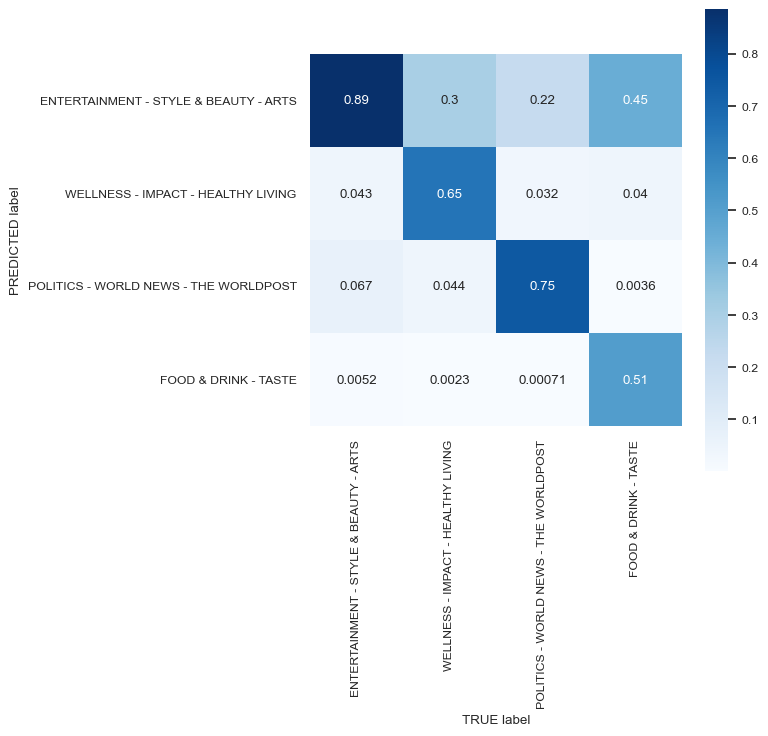

In [1623]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Fit the training data to the model
model = make_pipeline(TfidfVectorizer(**vectorizer_settings), MultinomialNB())
model.fit(x_train, y_train['cluster_category'])

# Test the model using reserved test data not included in the training
predicted_categories = model.predict(x_test)

# calculate the confusion matrix and overall F1 score
c_matrix = confusion_matrix(y_test['cluster_category'], predicted_categories, labels=dominant_categories, normalize='true')
f1_score_result = f1_score(y_test['cluster_category'], predicted_categories, average='micro')


print('Overall F1 Score: {:.2%}'.format(f1_score_result))

plt.rcParams.update({'font.size': 8, 'figure.figsize': [6, 6]})
sns.set_theme(font_scale=0.8)
sns.color_palette("Blues", as_cmap=True)
sns.heatmap(c_matrix.T, square=True, cmap='Blues', annot=True, cbar=True, xticklabels=dominant_categories, yticklabels=dominant_categories)
plt.xlabel('TRUE label')
plt.ylabel('PREDICTED label')

plt.show()

## **7** - Predict from user input

1. Prompt user to enter a headline
2. Use model to predict category for headline
3. Show the prediction to the user

This section can be run multiple times.

In [1624]:
headline = input('Enter a headline') # Prompt the user for a headline
pred = model.predict([headline]) # Use the model to make a prediction
print('The headline "' + headline + '" is in the category ' + pred[0]) # Show the prediction to the user

The headline "C.I.A. Now Favors Lab Leak Theory to Explain Covid’s Origins" is in the category POLITICS - WORLD NEWS - THE WORLDPOST
